In [468]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import optuna
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb
import catboost as cb
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier


In [330]:
import warnings
warnings.filterwarnings('ignore')

In [167]:
# function for preprocessing categorical features into numeric ones and filling in missing values
def conv_cat_to_numeric(df):
    df_res = df.copy()
    
    stress_mapping = {'Low': 0, 'Medium': 1, 'High': 2}
    df_res['stress_level'] = df_res['stress_level'].map(stress_mapping)
    
    df_res['mental_health_condition'] = df_res['mental_health_condition'].fillna(0)
    stress_mapping = {'Burnout': 2, 'Anxiety': 1, 0:0}
    df_res['mental_health_condition'] = df_res['mental_health_condition'].map(stress_mapping)

    gender_mapping = {'Male': 1, 'Female':0}
    df_res['gender'] = df_res['gender'].map(gender_mapping).astype(int)
        
    stress_mapping = {'Yes': 1, 'No':0}
    df_res['access_to_mental_health_resources'] = df_res['access_to_mental_health_resources'].map(stress_mapping).astype(int)
    
    mapping = {'Decrease': -1, 'No Change': 0, 'Increase': 1}
    df_res['productivity_change'] = df_res['productivity_change'].map(mapping).astype(int)
    
    mapping = {'Unsatisfied': -1, 'Neutral': 0, 'Satisfied': 1}
    df_res['satisfaction_with_remote_work'] = df_res['satisfaction_with_remote_work'].map(mapping).astype(int)
    
    work_location_mapping = {'Onsite': 0, 'Hybrid': 1, 'Remote': 2}
    df_res['work_location'] = df_res['work_location'].map(work_location_mapping).astype(int)
    
    df_res['physical_activity'] = df_res['physical_activity'].fillna(0)
    physical_activity_mapping = {0: 0, 'Weekly': 1, 'Daily': 2}
    df_res['physical_activity'] = df_res['physical_activity'].fillna(0).map(physical_activity_mapping)
    
    physical_activity_mapping = {'Average': 0, 'Poor': 1, 'Good': 2}
    df_res['sleep_quality'] = df_res['sleep_quality'].fillna(0).map(physical_activity_mapping)
    
    return df_res

### Uploading data

In [159]:
df = pd.read_csv('total_remote_work_info.csv')

df.sample(5)

,employee_id,age,gender,years_of_experience,work_location,hours_worked_per_week,number_of_virtual_meetings,work_life_balance_rating,stress_level,mental_health_condition,access_to_mental_health_resources,productivity_change,social_isolation_rating,satisfaction_with_remote_work,company_support_for_remote_work,physical_activity,sleep_quality
49,50,31,Female,8.0,Remote,40.0,1,3,High,Anxiety,No,Decrease,2,Satisfied,1,NaN,Poor
42,43,44,Male,20.0,Remote,40.0,1,5,Low,NaN,No,No Change,1,Satisfied,3,Daily,Average
2,3,26,Female,2.0,Hybrid,40.0,1,5,Medium,NaN,Yes,No Change,3,Satisfied,4,Daily,Good
29,30,46,Male,20.0,Hybrid,40.0,1,3,Medium,Burnout,No,No Change,3,Satisfied,3,Weekly,Good
64,65,21,Female,1.0,Remote,55.0,1,4,Medium,Anxiety,No,Increase,4,Satisfied,5,Weekly,Poor


In [118]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4400 entries, 0 to 4399
Data columns (total 17 columns):
 #   Column                             Non-Null Count  Dtype 
---  ------                             --------------  ----- 
 0   employee_id                        4400 non-null   object
 1   age                                4400 non-null   int64 
 2   gender                             4400 non-null   object
 3   years_of_experience                4400 non-null   int64 
 4   work_location                      4400 non-null   object
 5   hours_worked_per_week              4400 non-null   int64 
 6   number_of_virtual_meetings         4400 non-null   int64 
 7   work_life_balance_rating           4400 non-null   int64 
 8   stress_level                       4400 non-null   object
 9   mental_health_condition            3350 non-null   object
 10  access_to_mental_health_resources  4400 non-null   object
 11  productivity_change                4400 non-null   object
 12  social

let's delete employee_id since this column doesn't make any sense

In [369]:
df.drop(columns['employee_id'], inplace=True)

converting the data to a numeric format

In [177]:
df_test = conv_cat_to_numeric(df)

let's check the resulting values

In [514]:
df_test.sample(5)

,age,gender,years_of_experience,work_location,hours_worked_per_week,number_of_virtual_meetings,work_life_balance_rating,stress_level,mental_health_condition,access_to_mental_health_resources,productivity_change,social_isolation_rating,satisfaction_with_remote_work,company_support_for_remote_work,physical_activity,sleep_quality,age_exp_interaction,physical_satisfaction,workload,sleep_stress_ratio
3067,28,0,3,2,31,2,2,1,1,1,0,2,0,0,0,1,84,0,62,0.5
3749,28,0,4,0,47,0,1,0,2,0,0,0,0,0,0,0,112,0,0,0.0
2706,24,1,4,0,36,2,0,1,1,0,0,3,0,0,0,0,96,0,72,0.0
4476,17,1,2,1,34,0,0,0,2,0,0,2,0,0,0,0,34,0,0,0.0
305,24,0,4,1,35,1,3,1,0,1,0,2,1,4,1,2,96,1,35,1.0


the main statistical characteristics of the data

In [381]:
df_test.describe()

,age,gender,years_of_experience,work_location,hours_worked_per_week,number_of_virtual_meetings,work_life_balance_rating,stress_level,mental_health_condition,access_to_mental_health_resources,productivity_change,social_isolation_rating,satisfaction_with_remote_work,company_support_for_remote_work,physical_activity,sleep_quality
count,4057.000000,4057.000000,4057.000000,4057.000000,4057.000000,4057.000000,4057.000000,4057.000000,4057.000000,4057.000000,4057.000000,4057.000000,4057.000000,4057.000000,4057.000000,4057.000000
mean,28.440966,0.594281,4.518363,0.690165,40.540301,2.481883,2.339413,0.426670,0.818092,0.181661,-0.033522,2.178950,0.242544,2.484102,0.376633,0.594774
std,5.054294,0.491091,3.490862,0.715002,5.454077,1.659421,1.232334,0.599645,0.716072,0.385613,0.331395,1.191282,0.428674,1.355574,0.622258,0.729048
min,20.000000,0.000000,1.000000,0.000000,25.000000,0.000000,1.000000,0.000000,0.000000,0.000000,-1.000000,1.000000,0.000000,1.000000,0.000000,0.000000
25%,25.000000,0.000000,2.000000,0.000000,37.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000
50%,28.000000,1.000000,4.000000,1.000000,41.000000,2.000000,2.000000,0.000000,1.000000,0.000000,0.000000,2.000000,0.000000,2.000000,0.000000,0.000000
75%,31.000000,1.000000,6.000000,1.000000,44.000000,4.000000,3.000000,1.000000,1.000000,0.000000,0.000000,3.000000,0.000000,4.000000,1.000000,1.000000
max,54.000000,1.000000,24.000000,2.000000,62.000000,6.000000,5.000000,2.000000,2.000000,1.000000,1.000000,5.000000,1.000000,5.000000,2.000000,2.000000


### Distribution of variables

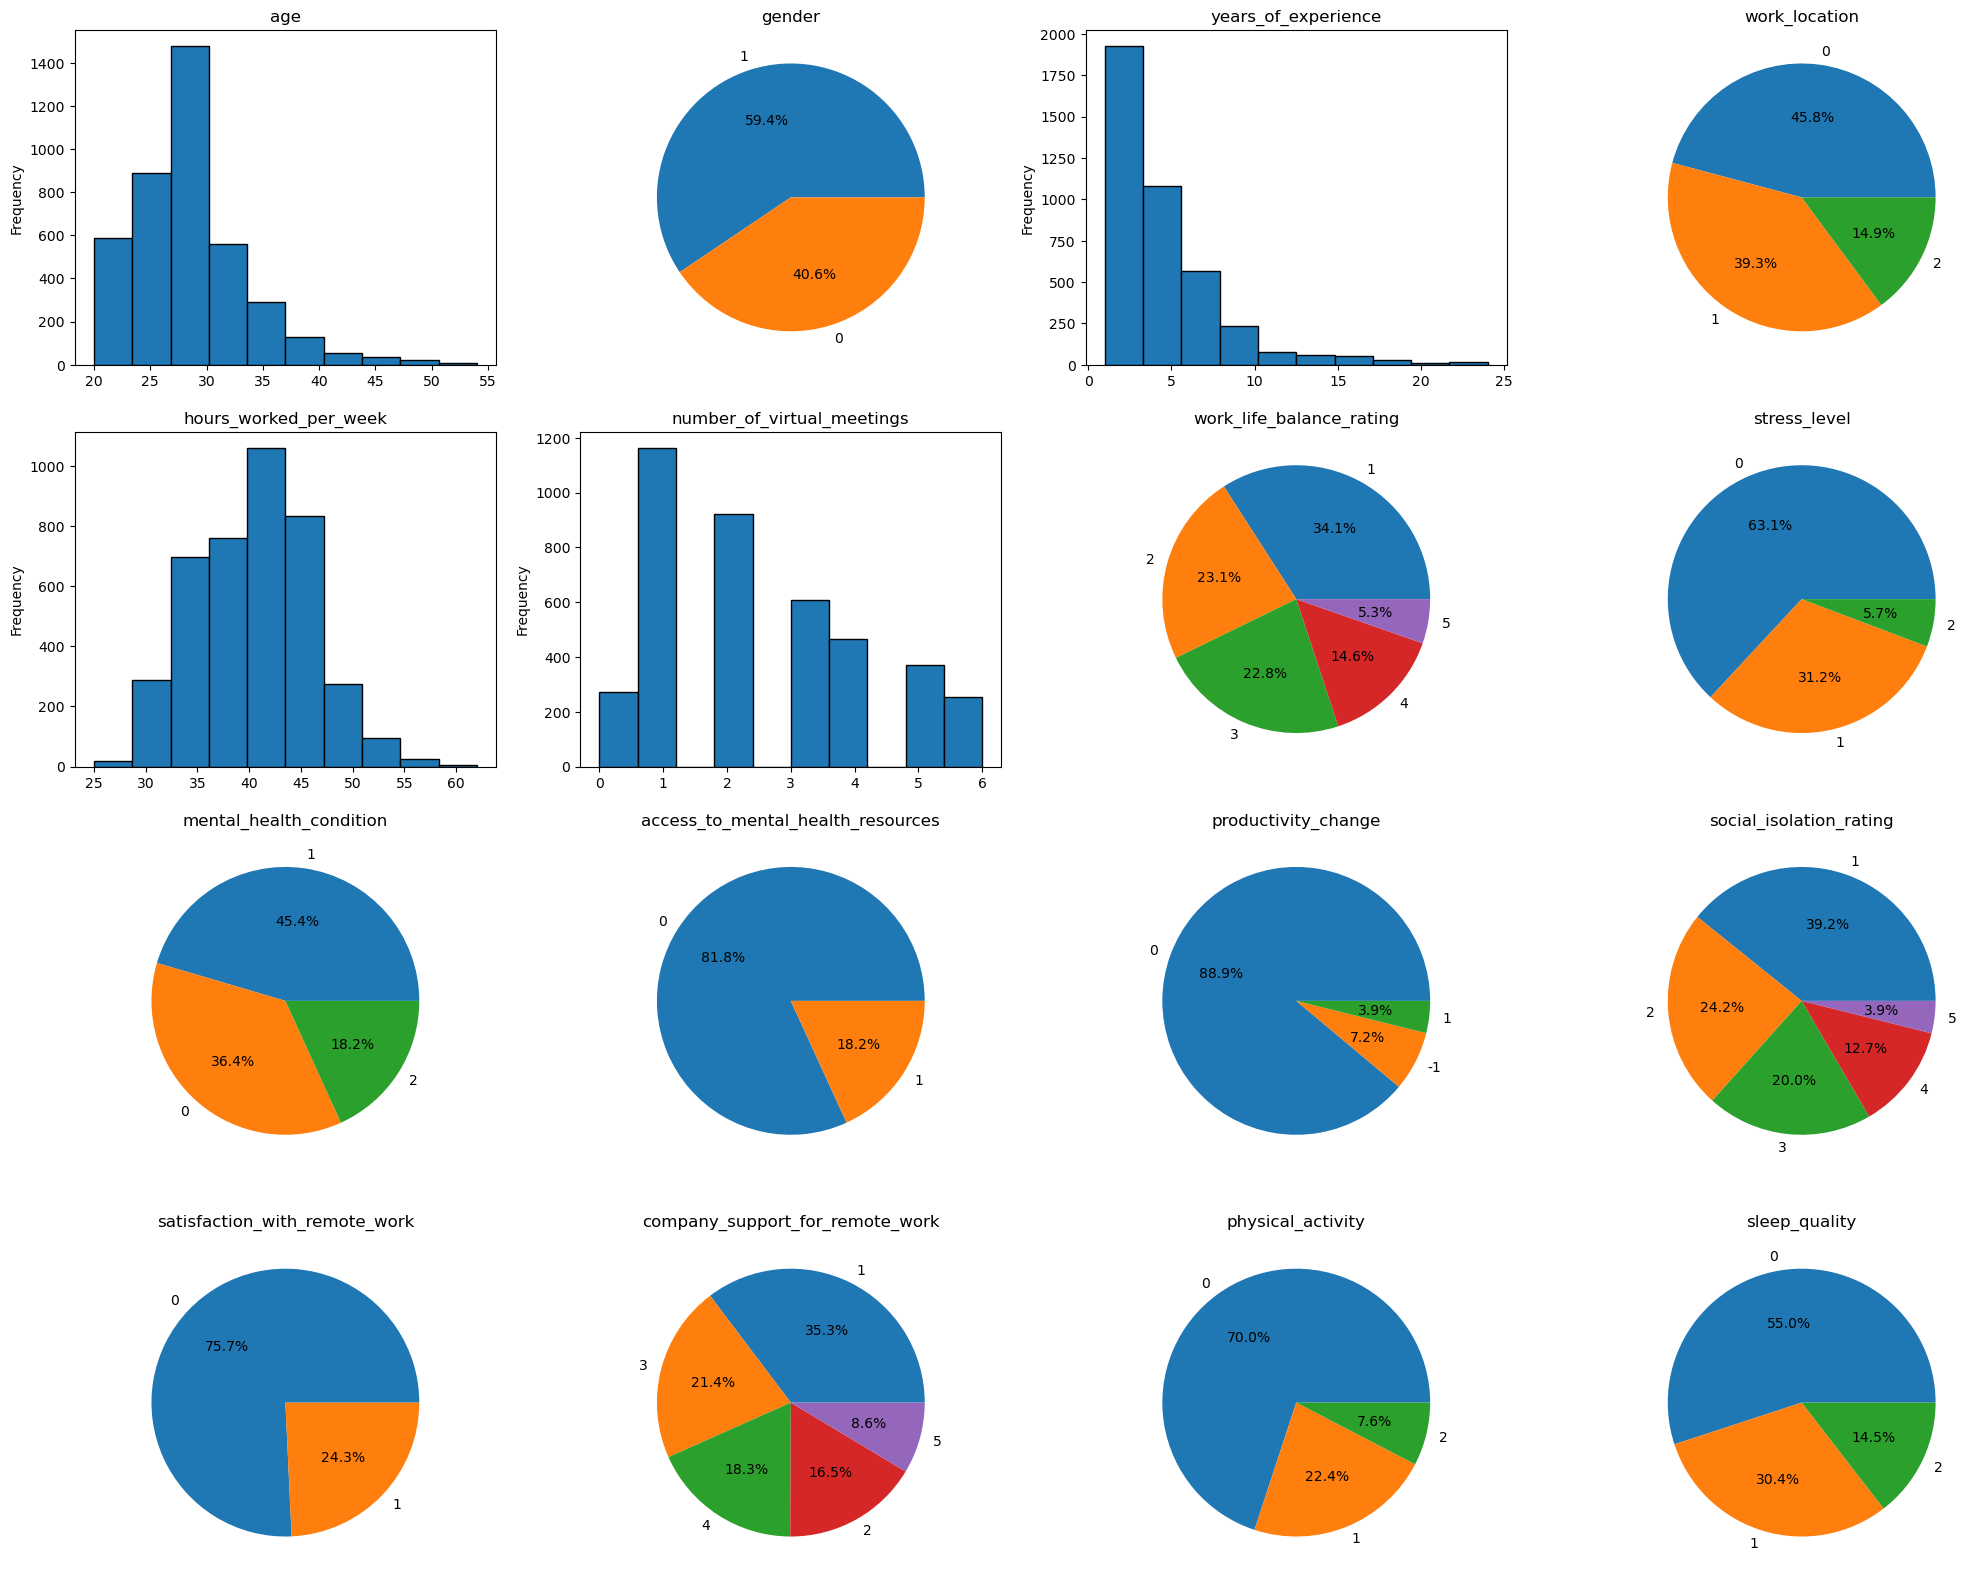

In [359]:
fig, axes = plt.subplots(4, 4, figsize=(25, 20))

for ax, col in zip(axes.flatten(), df_test.columns):
    ax.set_title(col)
    if col not in ["age", "hours_worked_per_week", "number_of_virtual_meetings", 'years_of_experience']:
        ax.pie(df_test[col].value_counts(), autopct="%1.1f%%", labels=df_test[col].value_counts().index)
    else:
        df_test[col].plot(kind="hist", ec="black", ax=ax)

distribution of the target variable

C:\Users\Alexey\AppData\Local\Temp\ipykernel_19572\1541791771.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=np.concatenate([


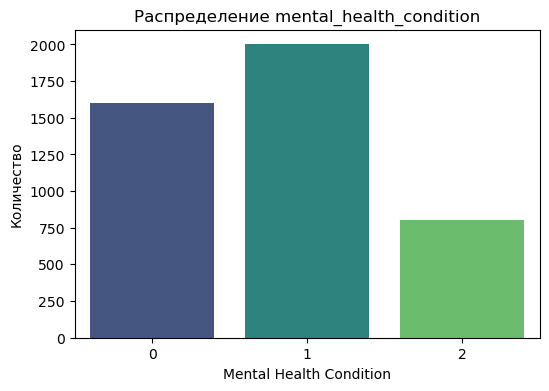

In [390]:
plt.figure(figsize=(6, 4))
sns.countplot(x=df_test["mental_health_condition"], palette="viridis")
plt.title("Распределение mental_health_condition")
plt.xlabel("Mental Health Condition")
plt.ylabel("Количество")
plt.show()


###     Correlation of features

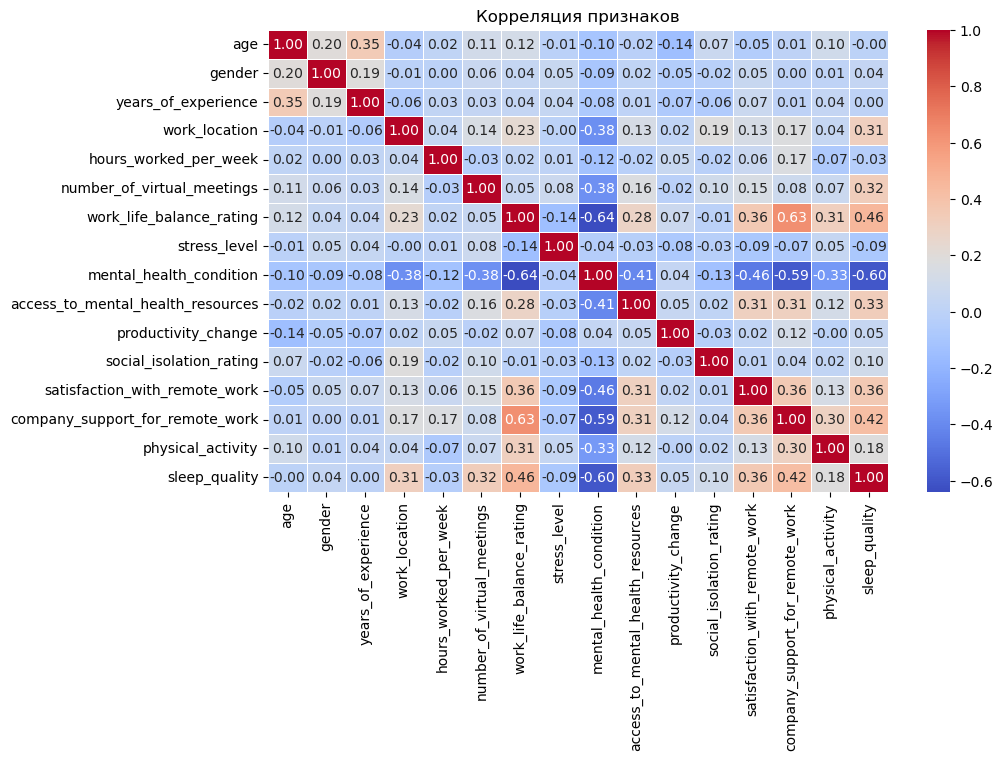

In [321]:
plt.figure(figsize=(10, 6))
sns.heatmap(df_test.corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Корреляция признаков")
plt.show()

correlation of features with the target variable

In [301]:
correlation = df_test.corr()['mental_health_condition'].sort_values(ascending=False)
print(correlation)

mental_health_condition              1.000000
productivity_change                  0.035545
stress_level                        -0.038786
gender                              -0.074040
years_of_experience                 -0.080353
age                                 -0.102171
hours_worked_per_week               -0.123665
social_isolation_rating             -0.128316
physical_activity                   -0.334217
number_of_virtual_meetings          -0.376264
work_location                       -0.381138
access_to_mental_health_resources   -0.411988
satisfaction_with_remote_work       -0.460631
company_support_for_remote_work     -0.585427
sleep_quality                       -0.599959
work_life_balance_rating            -0.638924
Name: mental_health_condition, dtype: float64


### Creating additional features

In [410]:
df_test["age_exp_interaction"] = df_test["age"] * df_test["years_of_experience"]
df_test["physical_satisfaction"] = df_test["physical_activity"] * df_test["satisfaction_with_remote_work"]
df_test["workload"] = df_test["hours_worked_per_week"] * df_test["number_of_virtual_meetings"]

df_test["sleep_stress_ratio"] = round(df_test["sleep_quality"] / (df_test["stress_level"] + 1), 2)
df_test["sleep_stress_ratio"] = np.where(np.isinf(df_test["sleep_stress_ratio"]), 0, df_test["sleep_stress_ratio"])
df_test["sleep_stress_ratio"] = round(df_test["sleep_stress_ratio"], 2)


### Standardizing the data

In [412]:
df_standard = df_test.copy()

features = df_test.columns.difference(['mental_health_condition']) 

scaler_standard = StandardScaler()
df_standard[features] = scaler_standard.fit_transform(df_standard[features])

df_standard.head()

,age,gender,years_of_experience,work_location,hours_worked_per_week,number_of_virtual_meetings,work_life_balance_rating,stress_level,mental_health_condition,access_to_mental_health_resources,productivity_change,social_isolation_rating,satisfaction_with_remote_work,company_support_for_remote_work,physical_activity,sleep_quality,age_exp_interaction,physical_satisfaction,workload,sleep_stress_ratio
0,0.467353,0.588825,0.012101,0.433802,-0.460963,0.764984,0.609335,-0.703481,0,-0.463446,0.067667,0.009921,1.813551,1.058456,-0.589208,1.968639,-0.025525,-0.304514,0.661960,2.336263
1,1.028680,0.588825,-0.055714,-0.960399,0.272743,1.524232,0.609335,-0.703481,0,2.157751,0.067667,0.704074,1.813551,1.058456,2.651603,1.968639,-0.052356,4.777295,1.580687,2.336263
2,0.607684,0.588825,-0.055714,0.433802,0.639596,0.005735,1.976815,-0.703481,0,2.157751,0.067667,0.009921,1.813551,1.058456,-0.589208,-0.802164,-0.065065,-0.304514,0.073975,-0.740441
3,0.327021,-1.698299,0.079915,-0.960399,1.006449,1.524232,-0.074405,0.949108,0,-0.463446,-2.945351,-0.684233,-0.551404,0.457724,-0.589208,-0.802164,0.011190,-0.304514,1.801181,-0.740441
4,0.186689,0.588825,-0.055714,0.433802,-0.094110,0.764984,1.293075,-0.703481,0,-0.463446,0.067667,-0.684233,-0.551404,-0.143008,1.031197,0.583238,-0.077774,-0.304514,0.735458,0.797911


### Splitting data into train and validation

In [414]:
# Разделение на X и y
X = df_standard.drop(columns=["mental_health_condition"]) 
y = df_standard["mental_health_condition"]  

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

### Creating a baseline model

In [50]:
lr = LogisticRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)
report = classification_report(y_val, y_pred, digits=3)
print(f"Classification Report:\n{report}\n")


Classification Report:
              precision    recall  f1-score   support

           0      0.800     0.923     0.857        13
           1      0.429     0.429     0.429         7
           2      0.375     0.300     0.333        10

    accuracy                          0.600        30
   macro avg      0.535     0.551     0.540        30
weighted avg      0.572     0.600     0.583        30




### Selection of parameters using optuna

The parameter selection outputs have been removed for the convenience of viewing the file in the repository.

#### LogisticRegression

In [ ]:
def objective(trial):
    C = trial.suggest_loguniform('C', 1e-4, 1e2)
    solver = trial.suggest_categorical('solver', ['lbfgs', 'liblinear', 'saga'])
    
    model = LogisticRegression(C=C, solver=solver, max_iter=100, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    return f1_score(y_val, y_pred, average='macro')

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=500)

print("Лучшие параметры:", study.best_params)
print("Лучшее f1_macro:", study.best_value)

In [416]:
lr = LogisticRegression(**study.best_params)
lr.fit(X_train, y_train)

LogisticRegression(C=0.09723601834438825, solver='liblinear')

In [420]:
y_pred = lr.predict(X_val)
report_lr = classification_report(y_val, y_pred, digits=3)

In [424]:
precision = precision_score(y_val, y_pred, average="macro") 
recall = recall_score(y_val, y_pred, average="macro")
f1 = f1_score(y_val, y_val, average="macro")

print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1-score: {f1:.3f}")

Precision: 0.815
Recall: 0.806
F1-score: 0.810


#### DecisionTreeClassifier

In [ ]:
def objective(trial):
    max_depth = trial.suggest_int('max_depth', 1, 20)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)
    
    model = DecisionTreeClassifier(
        max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, random_state=42
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    return f1_score(y_val, y_pred, average='macro')

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=500)

print("Лучшие параметры:", study.best_params)
print("Лучшее f1_macro:", study.best_value)

In [428]:
dt = DecisionTreeClassifier(**study.best_params)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=11, min_samples_leaf=10, min_samples_split=16)

In [432]:
y_pred = dt.predict(X_val)
report_dt = classification_report(y_val, y_pred, digits=3) 

In [434]:
precision = precision_score(y_val, y_pred, average="macro") 
recall = recall_score(y_val, y_pred, average="macro")
f1 = f1_score(y_val, y_pred, average="macro")

print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1-score: {f1:.3f}")

Precision: 0.812
Recall: 0.821
F1-score: 0.816


#### Random forest

In [ ]:
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 300)
    max_depth = trial.suggest_int('max_depth', 1, 20)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)
    
    model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    return f1_score(y_val, y_pred, average='macro')

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=500)

print("Лучшие параметры:", study.best_params)
print("Лучшее f1_macro:", study.best_value)

In [440]:
rf = RandomForestClassifier(**study.best_params)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=6, min_samples_leaf=13, min_samples_split=6,
                       n_estimators=112)

In [444]:
y_pred = rf.predict(X_val)
report_rf = classification_report(y_val, y_pred, digits=3)

In [442]:
precision = precision_score(y_val, y_pred, average="macro")  
recall = recall_score(y_val, y_pred, average="macro")
f1 = f1_score(y_val, y_pred, average="macro")

print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1-score: {f1:.3f}")

Precision: 0.829
Recall: 0.831
F1-score: 0.829


#### XGboost

In [ ]:
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 1.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 1.0),
        'use_label_encoder': False,
        'objective': 'binary:logistic',
        'eval_metric': 'logloss'
    }
    
    model = xgb.XGBClassifier(**params, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    return f1_score(y_val, y_pred, average='macro')

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=500)

print("Лучшие параметры:", study.best_params)
print("Лучшее f1_macro:", study.best_value)

In [448]:
xb = xgb.XGBClassifier(**study.best_params)
xb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8825242652823266, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.0011518015168189768,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.09579617792416033,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=114, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [454]:
y_pred = xb.predict(X_val)
report_xb = classification_report(y_val, y_pred, digits=3)

In [450]:
precision = precision_score(y_val, y_pred, average="macro")  
recall = recall_score(y_val, y_pred, average="macro")
f1 = f1_score(y_val, y_pred, average="macro")

print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1-score: {f1:.3f}")

Precision: 0.869
Recall: 0.827
F1-score: 0.847


#### GradientBoostingClassifier

In [ ]:
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0)
    }
    
    model = GradientBoostingClassifier(**params, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    return f1_score(y_val, y_pred, average='macro')

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=500)

print("Лучшие параметры:", study.best_params)
print("Лучшее f1_macro:", study.best_value)


In [456]:
gb = GradientBoostingClassifier(**study.best_params)
gb.fit(X_train, y_train)


GradientBoostingClassifier(learning_rate=0.2095616490869984, max_depth=4,
                           min_samples_leaf=12, min_samples_split=4,
                           n_estimators=111, subsample=0.8127602719342608)

In [458]:
y_pred = gb.predict(X_val)
report_gb = classification_report(y_val, y_pred, digits=3)

In [503]:
precision = precision_score(y_val, y_pred, average="macro")  
recall = recall_score(y_val, y_pred, average="macro")
f1 = f1_score(y_val, y_pred, average="macro")

print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1-score: {f1:.3f}")

Precision: 0.861
Recall: 0.828
F1-score: 0.855


#### LGBMClassifier

In [ ]:
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 50),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 1.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 1.0)
    }
    
    model = lgb.LGBMClassifier(**params, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    return f1_score(y_val, y_pred, average='macro')

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=500)

print("Лучшие параметры:", study.best_params)
print("Лучшее f1_macro:", study.best_value)


In [462]:
lb = lgb.LGBMClassifier(**study.best_params)
lb.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000960 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 630
[LightGBM] [Info] Number of data points in the train set: 3918, number of used features: 19
[LightGBM] [Info] Start training from score -1.120285
[LightGBM] [Info] Start training from score -0.895578
[LightGBM] [Info] Start training from score -1.326361


LGBMClassifier(colsample_bytree=0.7393493913174926,
               learning_rate=0.029116184494978655, max_depth=9,
               min_child_samples=7, n_estimators=294, num_leaves=20,
               reg_alpha=4.643251767109397e-08,
               reg_lambda=2.8698500315909564e-07, subsample=0.8724852103474607)

In [ ]:
y_pred = lb.predict(X_val)
report_lb = classification_report(y_val, y_pred, digits=3)

In [464]:
precision = precision_score(y_val, y_pred, average="macro")  
recall = recall_score(y_val, y_pred, average="macro")
f1 = f1_score(y_val, y_pred, average="macro")

print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1-score: {f1:.3f}")

Precision: 0.874
Recall: 0.839
F1-score: 0.856


#### catboost

In [ ]:
def objective(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 50, 300),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
        'depth': trial.suggest_int('depth', 3, 10),
        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-8, 10.0),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'bagging_temperature': trial.suggest_uniform('bagging_temperature', 0.0, 1.0),
        'random_strength': trial.suggest_loguniform('random_strength', 1e-8, 10.0),
        'verbose': 0
    }
    
    model = cb.CatBoostClassifier(**params, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    return f1_score(y_val, y_pred, average='macro')

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=500)

print("Лучшие параметры:", study.best_params)
print("Лучшее f1_macro:", study.best_value)

In [470]:
cbc = cbc.CatBoostClassifier(*study.best_params)
cbc.fit(X_train, y_train) 

0:	learn: 1.0388030	total: 7.35ms	remaining: 2.14s
1:	learn: 0.9874986	total: 32.1ms	remaining: 4.66s
2:	learn: 0.9452165	total: 38.7ms	remaining: 3.73s
3:	learn: 0.9075141	total: 42.7ms	remaining: 3.07s
4:	learn: 0.8736268	total: 45.9ms	remaining: 2.63s
5:	learn: 0.8441353	total: 48.8ms	remaining: 2.33s
6:	learn: 0.8178290	total: 51.8ms	remaining: 2.11s
7:	learn: 0.7943871	total: 54.8ms	remaining: 1.94s
8:	learn: 0.7720762	total: 58.3ms	remaining: 1.83s
9:	learn: 0.7520524	total: 61.8ms	remaining: 1.74s
10:	learn: 0.7339416	total: 65.3ms	remaining: 1.67s
11:	learn: 0.7178125	total: 69.1ms	remaining: 1.61s
12:	learn: 0.7019432	total: 73ms	remaining: 1.57s
13:	learn: 0.6877620	total: 76.5ms	remaining: 1.52s
14:	learn: 0.6752916	total: 79.4ms	remaining: 1.47s
15:	learn: 0.6627701	total: 82.8ms	remaining: 1.43s
16:	learn: 0.6509789	total: 88.2ms	remaining: 1.43s
17:	learn: 0.6401367	total: 94.5ms	remaining: 1.44s
18:	learn: 0.6298829	total: 101ms	remaining: 1.45s
19:	learn: 0.6200151	tota

In [472]:
y_pred = cbc.predict(X_val)
report_cb = classification_report(y_val, y_pred, digits=3)

In [474]:
precision = precision_score(y_val, y_pred, average="macro")  
recall = recall_score(y_val, y_pred, average="macro")
f1 = f1_score(y_val, y_pred, average="macro")

print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1-score: {f1:.3f}")

Precision: 0.841
Recall: 0.862
F1-score: 0.851


### SVC

In [ ]:
def objective(trial):
    kernel = trial.suggest_categorical('kernel', ['linear', 'poly', 'rbf', 'sigmoid'])
    
    params = { 'C': trial.suggest_loguniform('C', 1e-3, 100),
        'kernel': kernel,
        'gamma': trial.suggest_categorical('gamma', ['scale', 'auto'])    }
    
    if kernel == 'poly':
        params['degree'] = trial.suggest_int('degree', 2, 5)
        params['coef0'] = trial.suggest_uniform('coef0', 0.0, 1.0)
    elif kernel == 'sigmoid':
        params['coef0'] = trial.suggest_uniform('coef0', 0.0, 1.0)
    
    model = Pipeline([('scaler', StandardScaler()), ('svm', SVC(**params, random_state=42))])
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    return f1_score(y_val, y_pred, average='macro')

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=500)
print("Лучшие параметры:", study.best_params)
print("Лучшее f1_macro:", study.best_value)

In [478]:
cvc = SVC(**study.best_params)
cvc.fit(X_train, y_train)

SVC(C=0.011089920663488585, kernel='linear')

In [480]:
y_pred = cvc.predict(X_val)
report_cvc = classification_report(y_val, y_pred, digits=3)

In [482]:
precision = precision_score(y_val, y_pred, average="macro") 
recall = recall_score(y_val, y_pred, average="macro")
f1 = f1_score(y_val, y_pred, average="macro")

print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1-score: {f1:.3f}")

Precision: 0.824
Recall: 0.817
F1-score: 0.829


comparison of metrics of different models

In [ ]:
# print('LogisticRegression')
# print(report_lr)
# print('DecisionTreeClassifier')
# print(report_dt)
# print('Random forest')
# print(report_rf)
# print('XGboost')
# print(report_xb)
# print('GradientBoostingClassifier')
# print(report_gb)
# print('LGBMClassifier')
# print(report_lb)
# print('catboost')
# print(report_cb)
# print('SVC')
# print(report_cvc)

### Creating a VotingClassifier

In [494]:
from sklearn.ensemble import VotingClassifier

# Создаём ансамблевый классификатор 
voting_clf = VotingClassifier(
    estimators=[
        ("CatBoost", cbc),
        ("XGBoost", xb),
        ("LightGBM", lb)
    ],
    voting="soft"  # вероятности
)
voting_clf.fit(X_train, y_train)

0:	learn: 1.0388030	total: 5.71ms	remaining: 1.66s
1:	learn: 0.9874986	total: 9.01ms	remaining: 1.31s
2:	learn: 0.9452165	total: 11.9ms	remaining: 1.15s
3:	learn: 0.9075141	total: 14.9ms	remaining: 1.07s
4:	learn: 0.8736268	total: 18.6ms	remaining: 1.07s
5:	learn: 0.8441353	total: 21.7ms	remaining: 1.03s
6:	learn: 0.8178290	total: 25.1ms	remaining: 1.02s
7:	learn: 0.7943871	total: 27.9ms	remaining: 989ms
8:	learn: 0.7720762	total: 31ms	remaining: 975ms
9:	learn: 0.7520524	total: 34ms	remaining: 959ms
10:	learn: 0.7339416	total: 37.1ms	remaining: 948ms
11:	learn: 0.7178125	total: 39.7ms	remaining: 927ms
12:	learn: 0.7019432	total: 43ms	remaining: 924ms
13:	learn: 0.6877620	total: 46.2ms	remaining: 918ms
14:	learn: 0.6752916	total: 49.6ms	remaining: 917ms
15:	learn: 0.6627701	total: 52.5ms	remaining: 905ms
16:	learn: 0.6509789	total: 55.1ms	remaining: 891ms
17:	learn: 0.6401367	total: 58.3ms	remaining: 888ms
18:	learn: 0.6298829	total: 61.1ms	remaining: 878ms
19:	learn: 0.6200151	total: 

VotingClassifier(estimators=[('CatBoost',
                              <catboost.core.CatBoostClassifier object at 0x00000136CE0D2AE0>),
                             ('XGBoost',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.8825242652823266,
                                            device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=No...
                                            n_estimators=114, n_jobs=None,
                                            num_parallel_tree=None,
                                            objective='multi:softprob', ...)),
                             ('LightGBM',
                              LGBMClassifier(colsample_bytree=0.7393493913174926,
                                             learning_rate=0.029116184494978655,
                                             max_depth=9, min_child_samples=7,
                                             n_estimators=294, num_leaves=20,
                                             reg_alpha=4.643251767109397e-08,
                                             reg_lambda=2.8698500315909564e-07,
                                             subsample=0.8724852103474607))],
                 voting='soft')

In [496]:
y_pred_voting = voting_clf.predict(X_val)
report_voting = classification_report(y_val, y_pred_voting, digits=3)

In [500]:
precision = precision_score(y_val, y_pred_voting, average="macro")  
recall = recall_score(y_val, y_pred_voting, average="macro")
f1 = f1_score(y_val, y_pred_voting, average="macro")

print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1-score: {f1:.3f}")

Precision: 0.848
Recall: 0.881
F1-score: 0.864


### Checking on a test  data

In [220]:
df_t = pd.read_csv('test_remote_work_info.csv')#.drop(columns={'Employee_ID'})
df_t = conv_cat_to_numeric(df_t)

In [214]:
df_t["Age_Exp_Interaction"] = df_t["Age"] * df_t["Years_of_Experience"]
df_t["Workload"] = df_t["Hours_Worked_Per_Week"] * df_t["Number_of_Virtual_Meetings"]
df_t["Sleep_Stress_Ratio"] = round(df_t["Sleep_Quality"] / (df_t["Stress_Level"] + 1), 2)
df_t["Physical_Satisfaction"] = df_t["Physical_Activity"] * df_t["Satisfaction_with_Remote_Work"]

df_t["Sleep_Stress_Ratio"] = np.where(np.isinf(df_t["Sleep_Stress_Ratio"]), 0, df_t["Sleep_Stress_Ratio"])
df_t["Sleep_Stress_Ratio"] = round(df_t["Sleep_Stress_Ratio"], 2)


df_test_standard = df_t.copy()
features = df_t.columns.difference(['Mental_Health_Condition']) 
df_test_standard[features] = scaler_standard.transform(df_test_standard[features])

X_t = df_test_standard.drop(columns=["Mental_Health_Condition"])  
y_t = df_test_standard["Mental_Health_Condition"]  

In [ ]:
y_pred_final = voting_clf.predict(X_t)
report_voting = classification_report(y_t, y_pred_final, digits=3)
print("Voting Classifier Classification Report:\n", report_voting)

### Saving the model for further work

In [508]:
import pickle  
with open("model.pkl", "wb") as f:  
    pickle.dump(voting_clf, f)

#### feature importance

CatBoost Feature Importances:


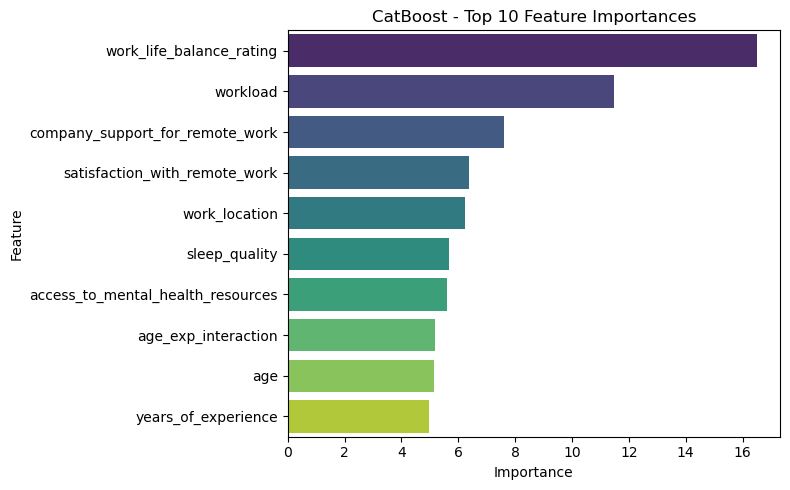

XGBoost Feature Importances:


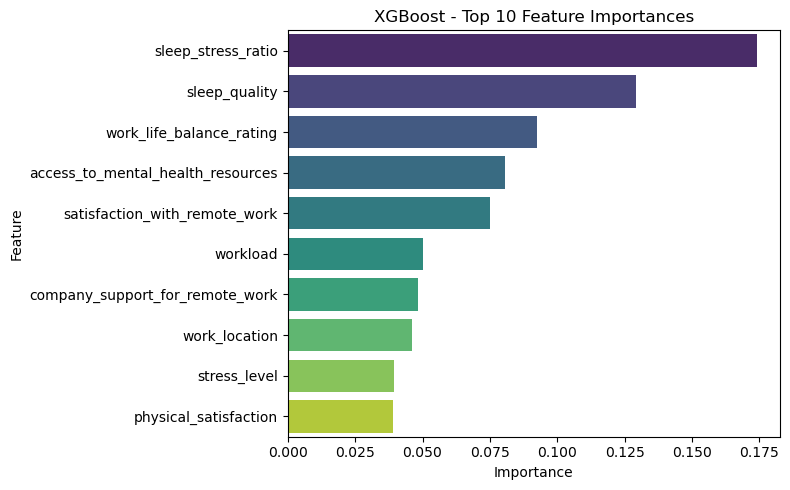

LightGBM Feature Importances:


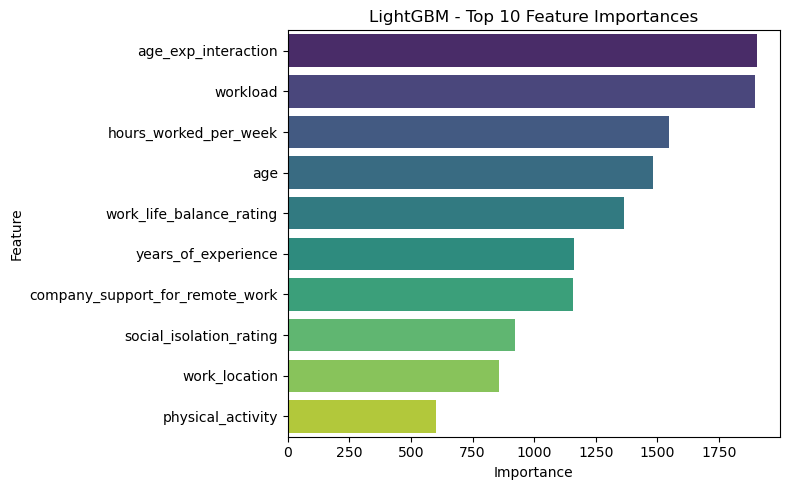

In [344]:
import matplotlib.pyplot as plt
import shap
import pandas as pd
import numpy as np
import seaborn as sns

feature_names = X_train.columns if hasattr(X_train, 'columns') else [f'feature_{i}' for i in range(X_train.shape[1])]

def plot_feature_importance(model, model_name):
    importances = model.feature_importances_
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False).head(10)  # только топ 10

    plt.figure(figsize=(8, 5))
    sns.barplot(x='Importance', y='Feature', data=importance_df, palette="viridis")
    plt.title(f'{model_name} - Top 10 Feature Importances')
    plt.tight_layout()
    plt.show()

def plot_shap(model, model_name, X_sample):
    explainer = shap.Explainer(model)
    shap_values = explainer(X_sample)

    shap_sum = np.abs(shap_values.values).mean(axis=0)
    top_inds = np.argsort(shap_sum)[-10:]  # индексы топ-10 фичей

    shap.summary_plot(shap_values[:, top_inds], X_sample.iloc[:, top_inds], feature_names=[feature_names[i] for i in top_inds], show=True)

X_sample = X_train.sample(n=500, random_state=42) if len(X_train) > 500 else X_train


print("CatBoost Feature Importances:")
plot_feature_importance(cb, "CatBoost")

print("XGBoost Feature Importances:")
plot_feature_importance(xb, "XGBoost")

print("LightGBM Feature Importances:")
plot_feature_importance(lb, "LightGBM")